In [133]:
import osmnx as ox
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import networkx as nx
import pyproj
from shapely.geometry import Point

import openrouteservice
from openrouteservice import convert

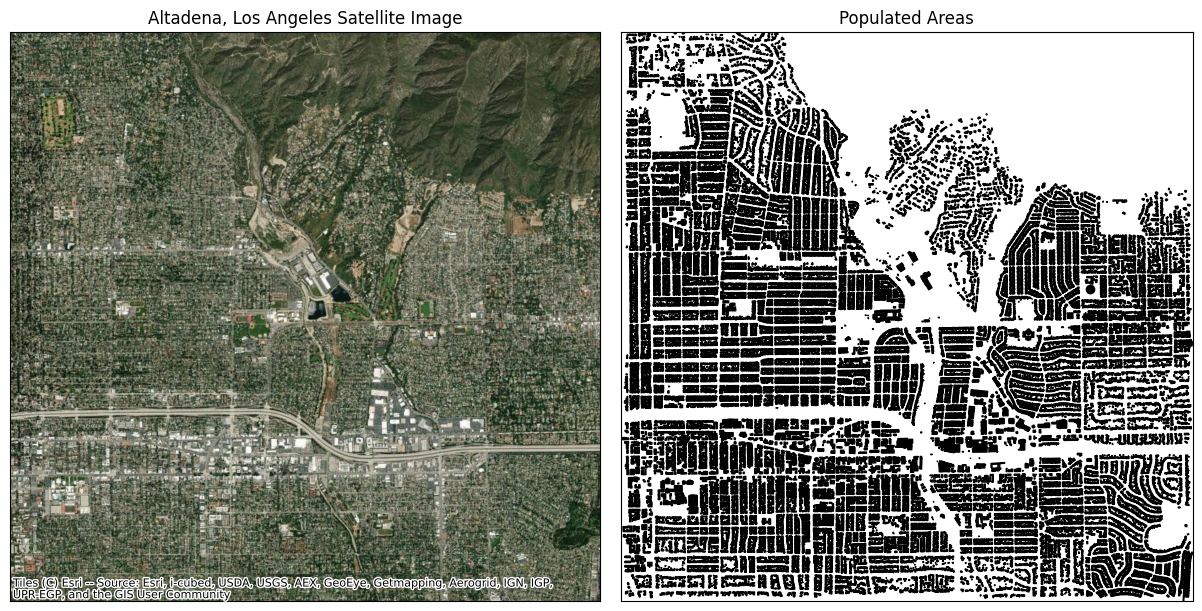

In [148]:
LATITUDE = 34.162598
LONGITUDE = -118.089578
RADIUS_MILES = 2
radius_meters = RADIUS_MILES * 1609.34

gdf = ox.features_from_point((LATITUDE, LONGITUDE),
                             dist=radius_meters,
                             tags={'building': True})

gdf = gdf.to_crs(epsg=3857)

min_x, min_y, max_x, max_y = gdf.total_bounds
extent = [min_x, max_x, min_y, max_y]

fig, axs = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)

ax_left = axs[1]
gdf.plot(ax=ax_left, color='black', edgecolor='black')
ax_left.set_title("Populated Areas")
ax_left.set_xlim(extent[:2])
ax_left.set_ylim(extent[2:])
ax_left.set_xticks([])
ax_left.set_yticks([])
ax_left.set_aspect("equal")

ax_right = axs[0]
ax_right.set_xlim(extent[:2])
ax_right.set_ylim(extent[2:])
ax_right.set_xticks([])
ax_right.set_yticks([])
ax_right.set_title("Altadena, Los Angeles Satellite Image")
ctx.add_basemap(ax_right, source=ctx.providers.Esri.WorldImagery)

In [154]:
grid_size = 10 # miles
threshold_meters = 1250 # meters

rows, cols = grid_size, grid_size
x_values = np.linspace(min_x, max_x, cols)
y_values = np.linspace(min_y, max_y, rows)

grid_points_3857 = [(x, y) for y in y_values for x in x_values]

transformer = pyproj.Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
grid_points_4326 = [transformer.transform(x, y) for (x, y) in grid_points_3857]  # (lon, lat)

print("downloading road network...")
G_drive = ox.graph_from_point(
    (LATITUDE, LONGITUDE),
    dist=radius_meters,
    network_type="drive"
)
print("road network downloaded.")

print("finding nearest road nodes...")
node_ids = [ox.distance.nearest_nodes(G_drive, lon, lat) for lon, lat in grid_points_4326]
print("nearest nodes found.")

G = nx.Graph()

for idx, node in enumerate(node_ids):
    G.add_node(idx, osmid=node)

neighbors_offset = [
    ( 0,  1), ( 0, -1),
    ( 1,  0), (-1,  0),
    ( 1,  1), ( 1, -1),
    (-1,  1), (-1, -1)
]

def get_index(r, c, ncols):
    return r * ncols + c

for r in range(rows):
    for c in range(cols):
        current_idx = get_index(r, c, cols)
        
        for dr, dc in neighbors_offset:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                neighbor_idx = get_index(nr, nc, cols)
                dist_m = nx.shortest_path_length(G_drive, node_ids[current_idx], node_ids[neighbor_idx], weight="length")
                # print(f"Distance from Node {current_idx} to Node {neighbor_idx}: {dist_m:.2f} meters")
                if dist_m < threshold_meters:
                    G.add_edge(current_idx, neighbor_idx, weight=dist_m)

print(f"\ngraph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

downloading road network...
road network downloaded.
finding nearest road nodes...
nearest nodes found.

graph: 100 nodes, 159 edges.


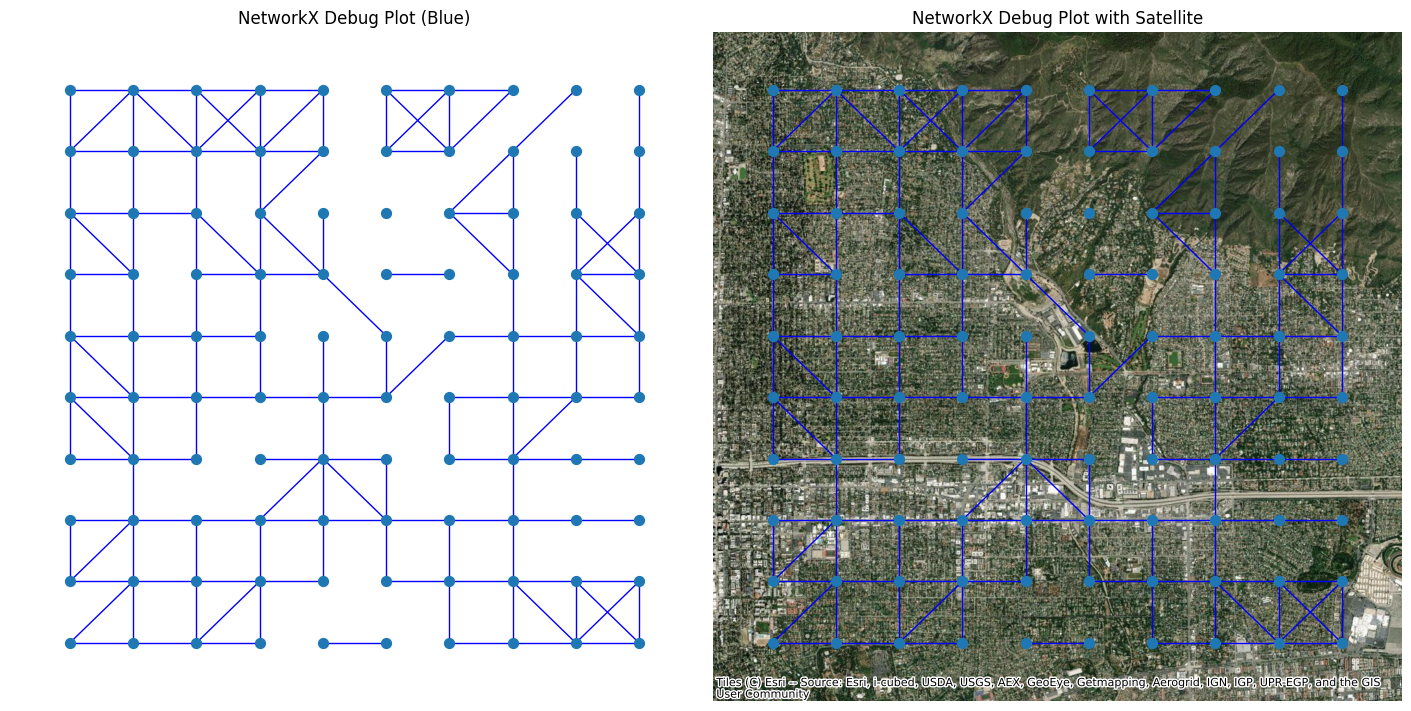

In [156]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

ax = axs[0]
nx.draw(G, pos={n: (grid_gdf.geometry.iloc[n].x, grid_gdf.geometry.iloc[n].y) for n in G.nodes()}, 
        node_size=50, edge_color="blue", with_labels=False, ax=ax)
ax.set_title("NetworkX Debug Plot (Blue)")

ax = axs[1]
nx.draw(G, pos={n: (grid_gdf.geometry.iloc[n].x, grid_gdf.geometry.iloc[n].y) for n in G.nodes()}, 
        node_size=50, edge_color="blue", with_labels=False, ax=ax)
ax.set_title("NetworkX Debug Plot with Satellite")
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

plt.show()

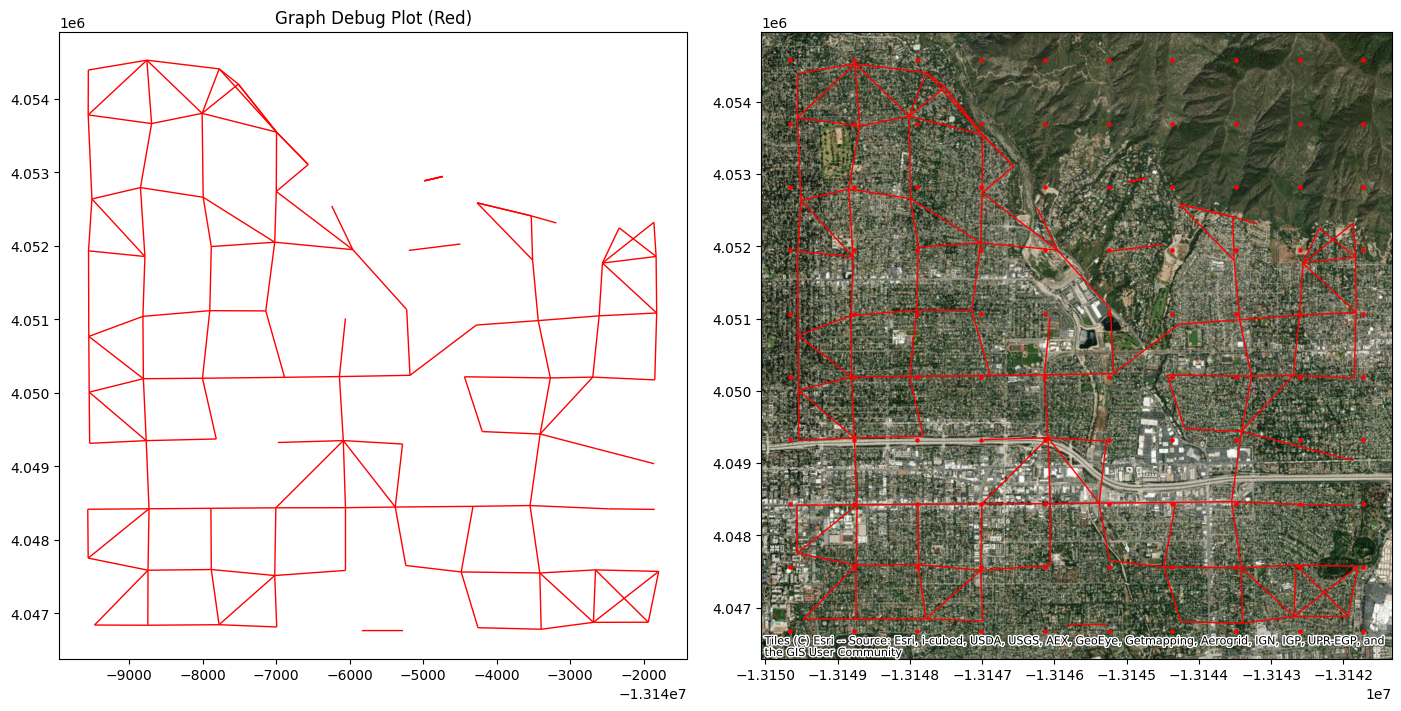

In [164]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
grid_gdf = gpd.GeoDataFrame(geometry=[Point(*transformer.transform(lon, lat)) for lon, lat in grid_points_4326], crs="EPSG:3857")

edges = []
for n1, n2 in G.edges():
    node1 = G.nodes[n1]["osmid"]
    node2 = G.nodes[n2]["osmid"]

    if node1 in G_drive.nodes and node2 in G_drive.nodes:
        lon1, lat1 = G_drive.nodes[node1]["x"], G_drive.nodes[node1]["y"]
        lon2, lat2 = G_drive.nodes[node2]["x"], G_drive.nodes[node2]["y"]

        x1, y1 = transformer.transform(lon1, lat1)
        x2, y2 = transformer.transform(lon2, lat2)

        edges.append(LineString([(x1, y1), (x2, y2)]))

edges_gdf = gpd.GeoDataFrame(geometry=edges, crs="EPSG:3857")
fig, axs = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

ax = axs[0]
edges_gdf.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Graph Debug Plot (Red)")

ax = axs[1]
edges_gdf.plot(ax=ax, color="red", linewidth=1)
grid_gdf.plot(ax=ax, marker="o", color="red", markersize=5)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

plt.show()